# Init libraries

In [1]:
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torchvision.datasets import ImageNet
from torchvision.transforms import ToTensor,Grayscale,Compose,RandomAffine, RandomHorizontalFlip, RandomVerticalFlip, Resize, functional
from torchvision.utils import make_grid
from torchvision.utils import save_image
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
from lpips import LPIPS
from torchvision.models import vgg16
from torch.utils.tensorboard import SummaryWriter
import time as time
import numpy as np
from IPython import display
import cv2

# Load Dataset and convert to grayscale

In [2]:
# Dataset class for the ImageNet dataset extending the torchvision ImageNet class
class ImageNetDataset(ImageNet):
    # Constructor
    def __init__(self, root, split='train', transform=None):
        # Calling the constructor of the parent class
        super().__init__(root, split=split, transform=transform)
        

    # Getting the image and label at a given index
    def __getitem__(self, index):
        return super().__getitem__(index)

    # Getting the length of the dataset
    def __len__(self):
        return super().__len__()
    
    

In [3]:
# Custom dataloader class for the ImageNet dataset 
class ImageNetDataLoader(DataLoader):
    # Constructor
    def __init__(self, root, batch_size, shuffle, split, transform=None, num_workers=0,img_subset=0):
        imgNet = ImageNetDataset(root, split=split, transform=transform)
        # Calling the constructor of the parent class and reduce the number of samples (must be a multiple of batch_size)
        if img_subset!=0:
            indices = torch.arange(img_subset)
            imgNet = Subset(imgNet, indices)
        super().__init__(imgNet,batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

    # Getting the image transformed to tensor and label at a given index
    def __getitem__(self, index):
        # Getting the image and label at the given index
        image, label = self.dataset[index]
        # Transforming the image to tensor
        image = functional.to_tensor(image)
        #Calculate mean and std of the image
        mean = torch.mean(image)
        std = torch.std(image)
        # Center the image
        image = functional.normalize(image, mean=mean, std=std)
        return image

    # Get the grayscale image transformed to tensor and label at a given index
    def get_grayscale_image(self, index):
        # Getting the image and label at the given index
        image, label = self.dataset[index]
        # Converting the image to grayscale
        image = functional.to_grayscale(image, num_output_channels=1)
        # Transforming the image to tensor
        image = functional.to_tensor(image)
        #Calculate mean and std of the image
        mean = torch.mean(image)
        std = torch.std(image)
        # Center the image
        image = functional.normalize(image, mean=mean, std=std)
        return image
    

    # Getting the length of the dataset
    def __len__(self):
        return super().__len__()

    

In [4]:
# Define transforms
#Train transforms
train_transform = Compose([
    #ToTensor(),
    RandomAffine((0.05, 0.05)),
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.5),
    Resize((256, 256))
])
#Test transforms
val_transform = Compose([
    Resize((256, 256))
])
# Data loaders
root="./dataset/imagenet/"
batch_size = 32
train_dataset = ImageNetDataLoader(root, batch_size, shuffle=True, split='train', transform=train_transform)
val_dataset = ImageNetDataLoader(root, batch_size, shuffle=False, split='val', transform=val_transform)
print("Train dataset length: ", len(train_dataset))
print("Validation dataset length: ", len(val_dataset))

Train dataset length:  40037
Validation dataset length:  1563


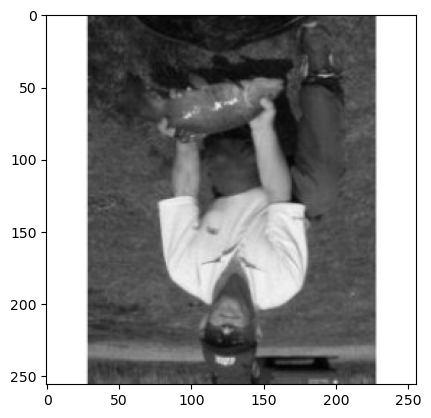

In [5]:
#Show an image from the dataset
image = train_dataset.get_grayscale_image(0)
plt.imshow(image[0], cmap='gray')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


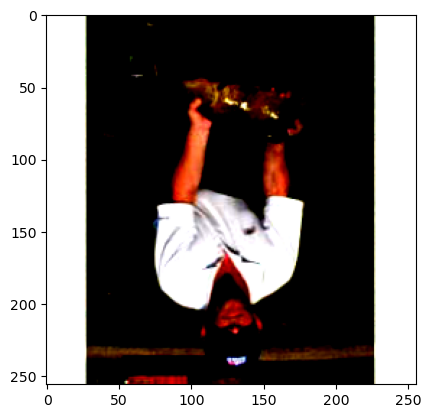

In [6]:
#Plot same image in colors
image = train_dataset.__getitem__(0)
plt.imshow(image.permute(1, 2, 0))

# UNET Autoencoder (Generator)
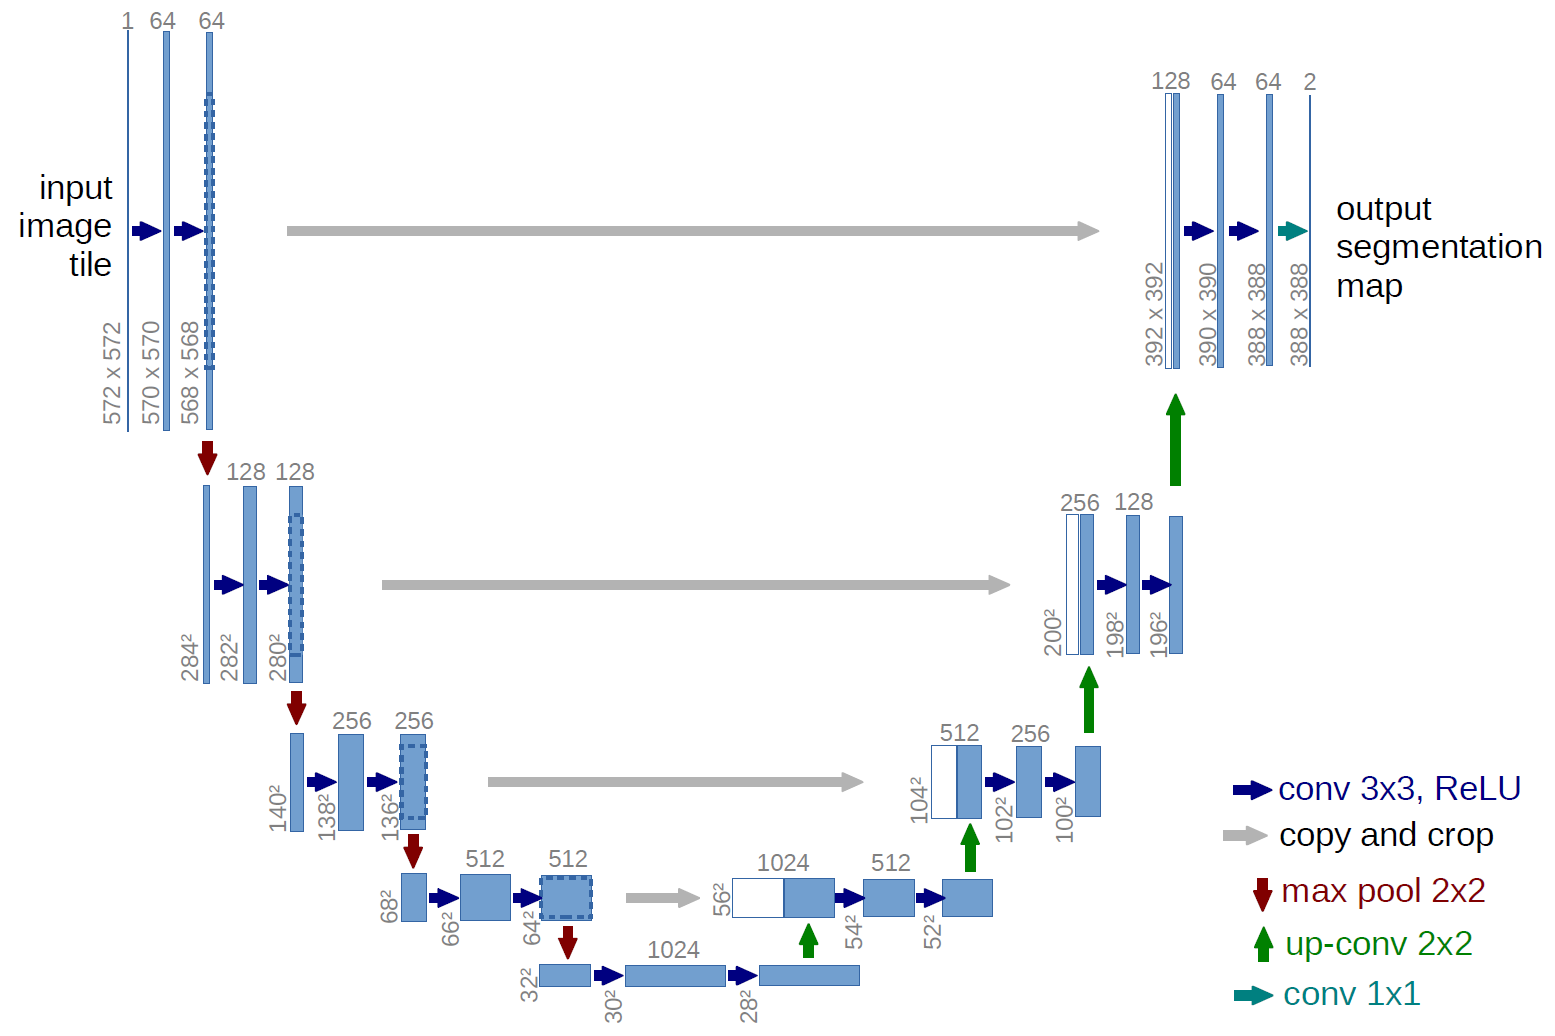

In [7]:
# Implement UNet autoencoder
class UNet(nn.Module):
    ## Constructor of the class 
    # Params:
    # in_channels= input image channels since in our case we are using grayscale images this is 1 for RGB images this would be 3
    # out_channels= outpute image channels since we want to get a colored image this is 3
    # featuress= list of numbers of output features for each block of the net (layer before max pooling) 
    # By default features are initialized like in the paper while in and out channel are already initialized how we want (can still be changed calling the constructor with different params) #
    def __init__(self, in_channels=1, out_channels=3,features=[64, 128, 256, 512]):
        super(UNet,self).__init__()
        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Encoder part of the network
        ## Iterate over the features list and create a double convolution block for each feature
        # after each iteration in_channels = feature since the next block in_channel is equals to the previous block output features
        # the bottom layer of the network is added later on#
        for feature in features:
            self.encoder_blocks.append(self.double_convolution(in_channels, feature))
            in_channels = feature
            # Maxpool not applied here because we need to save the output of the encoder block for the skip connection in the decoder part of the network
            
            
        # Decoder part of the network 
        # Iterate through the feature backwards (from the bottom to top of the image) #
        for feature in reversed(features):
            # Upconv part of the decoder block
            self.decoder_blocks.append(
                ## feature * 2 because the decoder block has 2 inputs 
                # (the output of the encoder block with skip connection and the output of the maxpooling of the previous decoder block)
                # kernel_size=2 and stride=2 upsample the image doubling width and height #
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
                )
            # Double convolution part of the decoder block 
            self.decoder_blocks.append(self.double_convolution(feature*2, feature))
        # Bottom layer of encoder/decoder part of the network
        # this layer is the last encoder block and first decoder block and as before uses doube convolution #
        self.bottom_layer = self.double_convolution(features[-1], features[-1]*2)
        # Final convolution layer of decoder part of the network 
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
    
    # Double convolution block utility function since both encoder and decoder have a double convolution for each block#
    def double_convolution(self,in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            # In the 2015 paper there was no batch normalization but it should be ok to add it
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    # Forward function of the network
    # Params:
    # self=self
    # x= input image
    def forward(self, x):
        # Store the skip connections for the decoder part of the network
        skip_connections = []
        # Encoder part of the network
        # Iterate over the encoder blocks and apply them to the input image
        # add x to the skip_connections list and then apply maxpool to x
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
            skip_connections.append(x)
            x = self.maxpool(x)    
        
        ## Bottom layer of the network
        # Apply the bottom layer to the output of the last encoder block #
        x = self.bottom_layer(x)
        # Decoder part of the network
        # Reverse the skip connections list to iterate from the bottom layer to the top one (List have been created from top to bottom)
        skip_connections = skip_connections[::-1]
        # Iterate over the decoder blocks and apply them to the input image
        # The starting index is 0 and the step is 2 because the decoder blocks list has 2 blocks for each layer (upconv and double convolution)
        for i in range(0, len(self.decoder_blocks), 2):
            # Get the skip connection for the current layer
            skip_connection = skip_connections[i//2]
            # Apply the upconv block to the input image
            x = self.decoder_blocks[i](x)

            ## Check if the output of the upconv block and the skip connection have the same size
            # If not crop the skip connection to the size of the output of the upconv block
            # In our use case should not be necessary since we resized images to 256x256 in the dataloader #
            if x.shape != skip_connection.shape:
                skip_connection = functional.interpolate(skip_connection, size=x.shape[2:])

            # Concatenate the output of the upconv block and the skip connection
            x = torch.cat((skip_connection, x), dim=1)
            # Apply the double convolution block to the concatenated image
            x = self.decoder_blocks[i+1](x)
        
        # Final convolution layer of the network
        return self.final_conv(x)




## Quick test to see if the unet model returns an image with the same shape than the original one

In [8]:

image = train_dataset.get_grayscale_image(0)
x = image.unsqueeze(0)
model = UNet()  
preds = model(x)
print(x.shape)
print(preds.shape)
## expected output:
# torch.Size([1, 1, 256, 256])
# torch.Size([1, 3, 256, 256]) 
# Output shape has 3 out channels since we want to go from grayscale to RGB #




torch.Size([1, 1, 256, 256])
torch.Size([1, 3, 256, 256])


# Discriminator

In [9]:
## Define the discriminator network (PatchGAN) 
# params:
# in_channels= channels of the input image + in channels of the unet output image (3 of input image + 3 of unet output image= 6)
# features: Number of out features for each conv block (as in UNet implementation) #
class Discriminator(nn.Module):
    def __init__(self, in_channels=6, features=[64, 128, 256, 512]):
        super().__init__()
        # Define the initial convolution block of the discriminator 
        self.initial= nn.Sequential(
            nn.Conv2d(in_channels, features[0], kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2)
        )
        # Define the rest of the convolution blocks of the discriminator
        self.layers = nn.ModuleList()
        in_channels = features[0]
        ## Iterate over the features list and apply a conv block to each element
        # The starting index is 1 because the first element of the features list is already used in the initial block
        # Stride is 2 for all the conv blocks except the last one #
        for i in range(1, len(features)):
            # Apply a conv block to the input image
            stride=1 if features[i] == features[-1] else 2
            self.layers.append(self.conv_block(features[i-1], features[i], stride))
            in_channels = features[i]
        # Add the final convolution block to the discriminator
        self.layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"))

    # Define the convolution blocks of the discriminator
    def conv_block(self, in_channels, out_channels, stride=2):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding_mode="reflect", bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    
    ## Define the forward function of the discriminator
    # params:
    # input_image= input image
    # unet_out_image= unet output image #
    def forward(self, input_image, unet_out_image):
        # Concatenate the input image and the unet output image
        x = torch.cat([input_image, unet_out_image], dim=1)
        # Apply the initial convolution block to the concatenated image
        x = self.initial(x)
        # Apply the rest of the convolution blocks to the output of the initial block
        for layer in self.layers:
            x = layer(x)
        
        return x


## Quick test to see if discriminator works

In [10]:
# Test the discriminator network
original_image = train_dataset.__getitem__(0)
grayscale_image = train_dataset.get_grayscale_image(0)
unet = UNet()
y = unet(grayscale_image.unsqueeze(0))
disc = Discriminator()
preds = disc(original_image.unsqueeze(0), y)
print(preds.shape)


torch.Size([1, 1, 26, 26])


## Training function

In [19]:

## Implement save_checkpoint function
# params:
# model= model to save
# optimizer= optimizer to save
# filename= name of the file to save the model
def save_checkpoint(model, optimizer, filename):
    state_dict = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict()
    }
    torch.save(state_dict, filename)

## Implement load_checkpoint function
# params:
# model= model to load
# optimizer= optimizer to load
# filename= name of the file to load the model
# lr= learning rate to use for the optimizer
def load_checkpoint(model, optimizer, filename, lr):
    state_dict = torch.load(filename)
    model.load_state_dict(state_dict["model_state_dict"])
    optimizer.load_state_dict(state_dict["optimizer_state_dict"])
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

## Save example images
# params:
# gen= generator network
# epoch= epoch number
#device= device to use
def save_examples(gen, epoch, device):
    # Load the images
    original_image = train_dataset.__getitem__(0)
    grayscale_image = train_dataset.get_grayscale_image(0)
    # Convert the images to tensors
    original_image = original_image.unsqueeze(0).to(device)
    grayscale_image = grayscale_image.unsqueeze(0).to(device)
    # Generate the image
    gen_image = gen(grayscale_image)
    
    # Save the images
    # Path to save the images in current folder
    path = "saved_samples/"
    # Create the path if it doesn't exist
    if not os.path.exists(path):
        os.makedirs(path)
    # Save the images
    # save_image(original_image, path + "original_image_" + str(epoch) + ".png")
    save_image(gen_image, path + "generated_image_" + str(epoch) + ".png")
    # save_image(grayscale_image, path + "grayscale_image_" + str(epoch) + ".png")

## Implement the training loop for the GAN
# params:
# epochs= number of epochs to train the model
# save_epoch= number of epochs to save the model
# loader= data loader
# gen= generator network
# disc= discriminator network
# opt_gen= optimizer for the generator
# opt_disc= optimizer for the discriminator
# l1= l1 loss function
# bce= bce loss function
# lpips= lpips loss function
# g_scaler= scaler for the generator
# d_scaler= scaler for the discriminator
# device= device to use
# discit= number of iteration to wait before training the discriminator
# disc_loss_lower_threshold= lower threshold for the discriminator loss
# vgg= vgg network for perceptual loss
def train(epochs, save_epoch, loader, gen, disc, opt_gen, opt_disc, l1, bce, g_scaler, d_scaler, device, discit, disc_loss_lower_threshold, lpips):
    # Load checkpoint if it exists
    if os.path.exists("gen_checkpoint.pth.tar"):
        load_checkpoint(gen, opt_gen, "gen_checkpoint.pth.tar", opt_gen.param_groups[0]["lr"])
    if os.path.exists("disc_checkpoint.pth.tar"):
        load_checkpoint(disc, opt_disc, "disc_checkpoint.pth.tar", opt_disc.param_groups[0]["lr"])
    # Iterate over the epochs
    for epoch in range(epochs):
        # Iterate over the data loader
        for idx in range(len(loader)):
            grayscale_image = loader.get_grayscale_image(idx)
            original_image = loader.__getitem__(idx)
            # Move the images to the device
            original_image = original_image.to(device)
            grayscale_image = grayscale_image.to(device)
            # Unsqueeze the images
            original_image = original_image.unsqueeze(0)
            grayscale_image = grayscale_image.unsqueeze(0)
            # Generate the image
            gen_image = gen(grayscale_image)
            gen_image = gen_image.to(device)
            #calculate mean and std of generated image
            mean = torch.mean(gen_image)
            std = torch.std(gen_image)
            # Center the generated image
            gen_image = functional.normalize(gen_image, mean=mean, std=std)
            # Train the discriminator every discit iterations of the generator and only if discriminator error is not too low
            if idx % discit == 0:
                # If cuda is enabled, use autocast
                if device == "cuda" | device == "cuda:0":
                    with torch.cuda.amp.autocast():
                        # Get the predictions from the discriminator
                        disc_real = disc(original_image, original_image)
                        disc_fake = disc(original_image, gen_image.detach())
                        # Calculate the discriminator loss
                        disc_loss = (bce(disc_real, torch.ones_like(disc_real)) + bce(disc_fake, torch.zeros_like(disc_fake)))/2
                else:
                    # Get the predictions from the discriminator
                    disc_real = disc(original_image, original_image)
                    disc_fake = disc(original_image, gen_image.detach())
                    # Calculate the discriminator loss
                    disc_loss = (bce(disc_real, torch.ones_like(disc_real)) + bce(disc_fake, torch.zeros_like(disc_fake)))/2
                # Apply the discriminator loss only if it is not too low
                if disc_loss > disc_loss_lower_threshold:
                    # Backpropagate the discriminator loss
                    opt_disc.zero_grad()
                    d_scaler.scale(disc_loss).backward()
                    d_scaler.step(opt_disc)
                    d_scaler.update()
           
           
            # Train the generator
            # If cuda is enabled, use autocast
            if device == "cuda" | device == "cuda:0":
                with torch.cuda.amp.autocast():
                    # Get the predictions from the discriminator
                    disc_fake = disc(original_image, gen_image)
                    # Calculate the generator loss
                    gen_loss = bce(disc_fake, torch.ones_like(disc_fake)) + l1(gen_image, original_image)
                    # Apply the perceptual loss
                    lpips_loss = lpips(gen_image, original_image)  
                    # Add the perceptual loss to the generator loss
                    gen_loss += lpips_loss
            else:
                # Get the predictions from the discriminator
                disc_fake = disc(original_image, gen_image)
                # Calculate the generator loss
                gen_loss = bce(disc_fake, torch.ones_like(disc_fake)) + l1(gen_image, original_image)
                # Apply the perceptual loss
                lpips_loss = lpips(gen_image, original_image)  
                lpips_loss = lpips_loss.squeeze()
                # Add the perceptual loss to the generator loss
                gen_loss += lpips_loss
                

            # Backpropagate the generator loss
            opt_gen.zero_grad()
            g_scaler.scale(gen_loss).backward()
            g_scaler.step(opt_gen)
            g_scaler.update()
            if idx % 100 == 0:
                # Print the losses
                print(f"Epoch: {epoch} | Batch: {idx} | Generator Loss: {gen_loss.item()} | Discriminator Loss: {disc_loss.item()}")
        #save checkpoint
        if epoch % save_epoch == 0:
            save_checkpoint(gen, opt_gen, "gen_checkpoint.pth.tar")
            save_checkpoint(disc, opt_disc, "disc_checkpoint.pth.tar")
        # Save some images
        save_examples(gen, epoch, device)

    


In [20]:
## Train the model
# Define the hyperparameters
epochs = 100
save_epoch = 1
# Define the data loader
train_loader = ImageNetDataLoader(root, batch_size=32, shuffle=True, split='train', transform=train_transform, img_subset=0, num_workers=8)
print("Train size: ", len(train_loader))
#Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Define the generator network
gen = UNet().to(device)
# Define the discriminator network
disc = Discriminator().to(device)
# Define the optimizers
opt_gen = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))
# Define the loss functions
l1 = nn.L1Loss()
bce = nn.BCEWithLogitsLoss()
# Define the perceptual loss
lpips_loss = LPIPS(net='vgg').to(device)
#Define the scaler
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()
# Set the model to train mode
gen.train()
disc.train()


# Train the model
train(epochs, save_epoch, train_loader, gen, disc, opt_gen, opt_disc, l1, bce, g_scaler, d_scaler, device, discit=3, disc_loss_lower_threshold=0.1, lpips=lpips_loss)


Train size:  40037
cuda
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: C:\Users\aless\AppData\Roaming\Python\Python39\site-packages\lpips\weights\v0.1\vgg.pth
gen tensor(4.1826, device='cuda:0', grad_fn=<AddBackward0>)
lpips_loss tensor([[[[0.7976]]]], device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0 | Batch: 0 | Generator Loss: 4.980154991149902 | Discriminator Loss: 0.03160860016942024
gen tensor(5.0827, device='cuda:0', grad_fn=<AddBackward0>)
lpips_loss tensor([[[[0.8124]]]], device='cuda:0', grad_fn=<AddBackward0>)
gen tensor(4.2729, device='cuda:0', grad_fn=<AddBackward0>)
lpips_loss tensor([[[[0.7191]]]], device='cuda:0', grad_fn=<AddBackward0>)
gen tensor(4.9486, device='cuda:0', grad_fn=<AddBackward0>)
lpips_loss tensor([[[[0.8052]]]], device='cuda:0', grad_fn=<AddBackward0>)
gen tensor(3.8619, device='cuda:0', grad_fn=<AddBackward0>)
lpips_loss tensor([[[[0.7371]]]], device='cuda:0', grad_fn=<AddBackward0>)
gen tensor(5.0180, devic

gen tensor(4.9688, device='cuda:0', grad_fn=<AddBackward0>)
lpips_loss tensor([[[[0.7405]]]], device='cuda:0', grad_fn=<AddBackward0>)
gen tensor(5.3728, device='cuda:0', grad_fn=<AddBackward0>)
lpips_loss tensor([[[[0.7503]]]], device='cuda:0', grad_fn=<AddBackward0>)
gen tensor(4.2466, device='cuda:0', grad_fn=<AddBackward0>)
lpips_loss tensor([[[[0.8144]]]], device='cuda:0', grad_fn=<AddBackward0>)
gen tensor(4.0160, device='cuda:0', grad_fn=<AddBackward0>)
lpips_loss tensor([[[[0.7250]]]], device='cuda:0', grad_fn=<AddBackward0>)
gen tensor(4.8957, device='cuda:0', grad_fn=<AddBackward0>)
lpips_loss tensor([[[[0.7364]]]], device='cuda:0', grad_fn=<AddBackward0>)
gen tensor(4.4712, device='cuda:0', grad_fn=<AddBackward0>)
lpips_loss tensor([[[[0.7906]]]], device='cuda:0', grad_fn=<AddBackward0>)
gen tensor(5.0016, device='cuda:0', grad_fn=<AddBackward0>)
lpips_loss tensor([[[[0.7776]]]], device='cuda:0', grad_fn=<AddBackward0>)
gen tensor(3.9845, device='cuda:0', grad_fn=<AddBackwar

gen tensor(3.4609, device='cuda:0', grad_fn=<AddBackward0>)
lpips_loss tensor([[[[0.7017]]]], device='cuda:0', grad_fn=<AddBackward0>)
gen tensor(4.2137, device='cuda:0', grad_fn=<AddBackward0>)
lpips_loss tensor([[[[0.7137]]]], device='cuda:0', grad_fn=<AddBackward0>)
gen tensor(4.5300, device='cuda:0', grad_fn=<AddBackward0>)
lpips_loss tensor([[[[0.7599]]]], device='cuda:0', grad_fn=<AddBackward0>)
gen tensor(4.9725, device='cuda:0', grad_fn=<AddBackward0>)
lpips_loss tensor([[[[0.7391]]]], device='cuda:0', grad_fn=<AddBackward0>)
gen tensor(5.0621, device='cuda:0', grad_fn=<AddBackward0>)
lpips_loss tensor([[[[0.7534]]]], device='cuda:0', grad_fn=<AddBackward0>)
gen tensor(4.7308, device='cuda:0', grad_fn=<AddBackward0>)
lpips_loss tensor([[[[0.7311]]]], device='cuda:0', grad_fn=<AddBackward0>)
gen tensor(5.0365, device='cuda:0', grad_fn=<AddBackward0>)
lpips_loss tensor([[[[0.7596]]]], device='cuda:0', grad_fn=<AddBackward0>)
gen tensor(4.2395, device='cuda:0', grad_fn=<AddBackwar

KeyboardInterrupt: 

In [ ]:
## Validate function
def validate(loader, gen, device):
    # Set the generator to eval mode
    gen.eval()
    # Initialize the loss function
    l1 = nn.L1Loss()
    # Initialize the loss
    loss = 0
    # Iterate over the data loader
    for idx in range(len(loader)):
        # Get the images
        grayscale_image = loader.get_grayscale_image(idx)
        original_image = loader.__getitem__(idx)
        # Move the images to the device
        original_image = original_image.to(device)
        grayscale_image = grayscale_image.to(device)
        # Unsqueeze the images
        original_image = original_image.unsqueeze(0)
        grayscale_image = grayscale_image.unsqueeze(0)
        # Generate the image
        with torch.cuda.amp.autocast():
            gen_image = gen(grayscale_image)
        # Calculate the loss
        loss += l1(gen_image, original_image)
        path = "saved_samples/validation"
        # Create the path if it doesn't exist
        if not os.path.exists(path):
            os.makedirs(path)
        # Save the images
        save_image(gen_image, f"{path}/validation_{idx}.png")
        save_image(original_image, f"{path}/original_{idx}.png")
    # Calculate the average loss
    loss /= len(loader)
    print(f"Validation loss: {loss}")

## Validate the model
# Define the data loader
val_loader = ImageNetDataLoader(root, batch_size=8, shuffle=True, split='val', transform=val_transform, img_subset=800, num_workers=8)
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define the generator network
gen = UNet().to(device)
# Load the checkpoint
if os.path.exists("gen_checkpoint.pth.tar"):
    load_checkpoint(gen, opt_gen, "gen_checkpoint.pth.tar", opt_gen.param_groups[0]["lr"])
# Validate the model on the validation set, save the images and calculate loss
validate(val_loader, gen, device)


